In [1]:
# view how polyfit make sense with FX data (oanda)

In [2]:
from OANDA_FUNC_CONF import *
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

In [3]:
# accountID = '101-011-15612193-001'
# access_token = '2897d1ae787989d30996a8a9d0a2c03d-7304ab578b56ccb454d311ecbc90cfdb'
# api = API(access_token=access_token, environment="practice")

In [4]:
dd = Data("H1", 5000)

In [5]:
bbWindow = 220
b = dd.bband(window=bbWindow)

In [6]:

testb = b[['raw', 'time', 'mean', 'upper', 'upper1', 'lower1',
	'lower', ]]
test = testb.iloc[:2000,:]

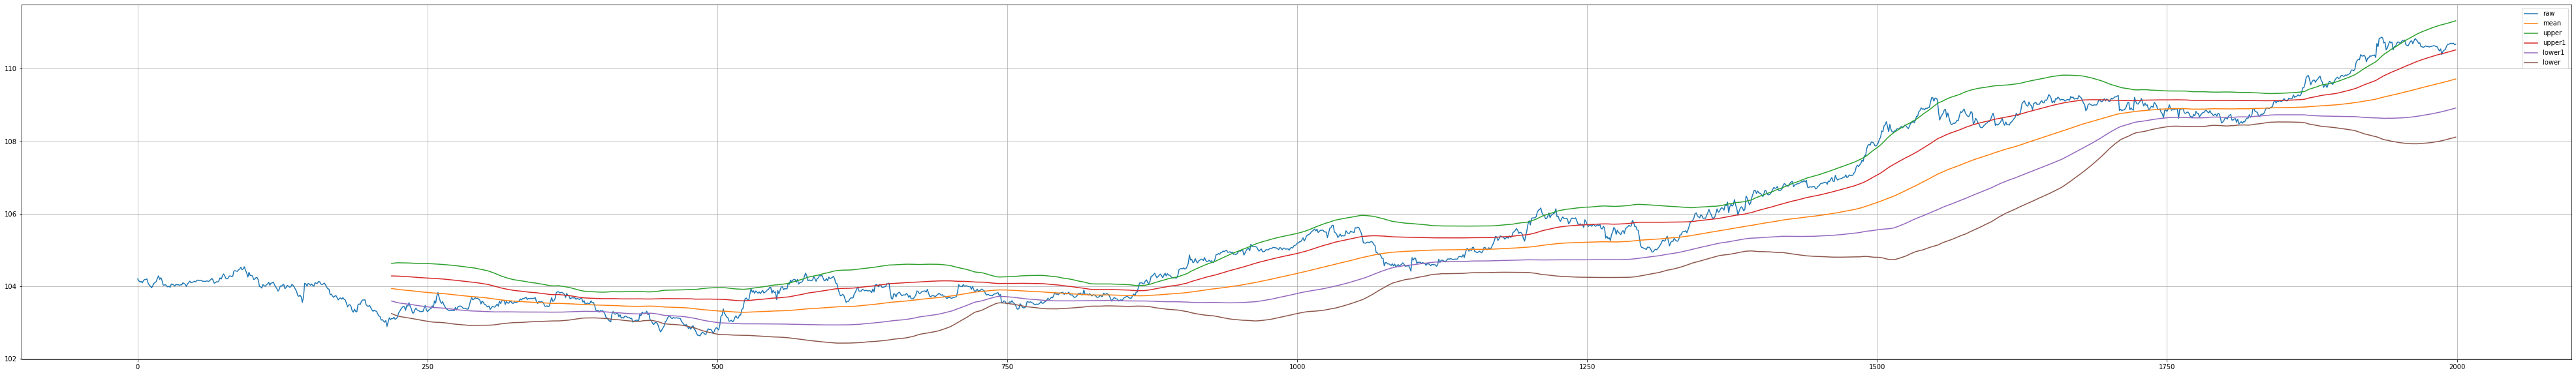

In [7]:
fig = test.plot(figsize=(70, 10), grid=True).get_figure()
fig.savefig("test.png")

In [8]:
def fitBB(bb, count):
	bb = bb[['raw', 'time', 'mean', 'upper', 'upper1', 'lower1',
       'lower', ]]

	bb = bb.iloc[:count,:]
	inAbove = False
	inBelow = False
	uCount = 0
	dCount = 0
	for i, row in bb.iterrows():
		if i < bbWindow:
			continue
		if row["raw"] > row["upper"]:
			if inAbove:
				continue
			else:
				inAbove = True
				uCount += 1
		elif row["raw"] < row["lower"]:
			if inBelow:
				continue
			else:
				inBelow = True
				dCount += 1
		else:
			inAbove = False
			inBelow = False
	return (uCount, dCount)
		
    
def fitBB1(bb, count):
	bb = bb[['raw', 'time', 'mean', 'upper', 'upper1', 'lower1',
       'lower', ]]

	bb = bb.iloc[:count,:]
	inAbove = False
	inBelow = False
	uCount = 0
	dCount = 0
	lastState = 0
	faultCount = 0 
	for i, row in bb.iterrows():
		if i < bbWindow:
			continue
		if row["raw"] > row["upper"]:
			if inAbove:
				continue
			else:
				inAbove = True
				uCount += 1
				if lastState == 1:
					faultCount += 1
		elif row["raw"] < row["lower"]:
			if inBelow:
				continue
			else:
				inBelow = True
				dCount += 1
				if lastState == -1:
					faultCount += 1
		else:
			if inAbove:
				lastState = 1
				inAbove = False
			elif inBelow:
				inBelow = False
				lastState = -1
			inAbove = False
			inBelow = False
	return round(faultCount / (uCount+dCount) ,3), (uCount, dCount)

In [9]:
fitBB1(b,3000)

(0.891, (40, 15))

In [10]:
def chooseOptPolicy1(dd, fitBBWindow=3000): # dd from Data class
	policies = [i for i in range(30,300, 10)]
	results = {}

	for p in policies:
		b = dd.bband(window=p)
		r = fitBB1(b, fitBBWindow) # count is length to estimate opt plicy
		results[p] = r
	print(results)
	opti = np.argmin([abs(v[1][0] - v[1][1]) for v in results.values()])
	opt = [v for i, v in enumerate(results.keys()) if i == opti][0]
	return opt

def chooseOptPolicy(dd, fitBBWindow=3000): # dd from Data class
	policies = [i for i in range(30,300, 10)]
	results = {}

	for p in policies:
		b = dd.bband(window=p)
		r = fitBB(b, fitBBWindow) # count is length to estimate opt plicy
		results[p] = r
	print(results)
	opti = np.argmin([abs(v[0] - v[1]) for v in results.values()])
	opt = [v for i, v in enumerate(results.keys()) if i == opti][0]
	return opt


In [11]:
# get opt policy
opts = chooseOptPolicy1(dd, fitBBWindow=3000)


{30: (0.714, (67, 59)), 40: (0.789, (62, 52)), 50: (0.796, (58, 50)), 60: (0.796, (50, 48)), 70: (0.768, (47, 35)), 80: (0.787, (41, 39)), 90: (0.793, (46, 36)), 100: (0.779, (41, 36)), 110: (0.764, (37, 35)), 120: (0.776, (43, 33)), 130: (0.776, (41, 35)), 140: (0.805, (43, 44)), 150: (0.849, (48, 38)), 160: (0.835, (47, 32)), 170: (0.811, (49, 25)), 180: (0.803, (42, 29)), 190: (0.781, (37, 27)), 200: (0.803, (40, 21)), 210: (0.867, (41, 19)), 220: (0.891, (40, 15)), 230: (0.875, (33, 15)), 240: (0.88, (34, 16)), 250: (0.92, (38, 12)), 260: (0.92, (37, 13)), 270: (0.92, (39, 11)), 280: (0.911, (35, 10)), 290: (0.902, (29, 12))}


<AxesSubplot:>

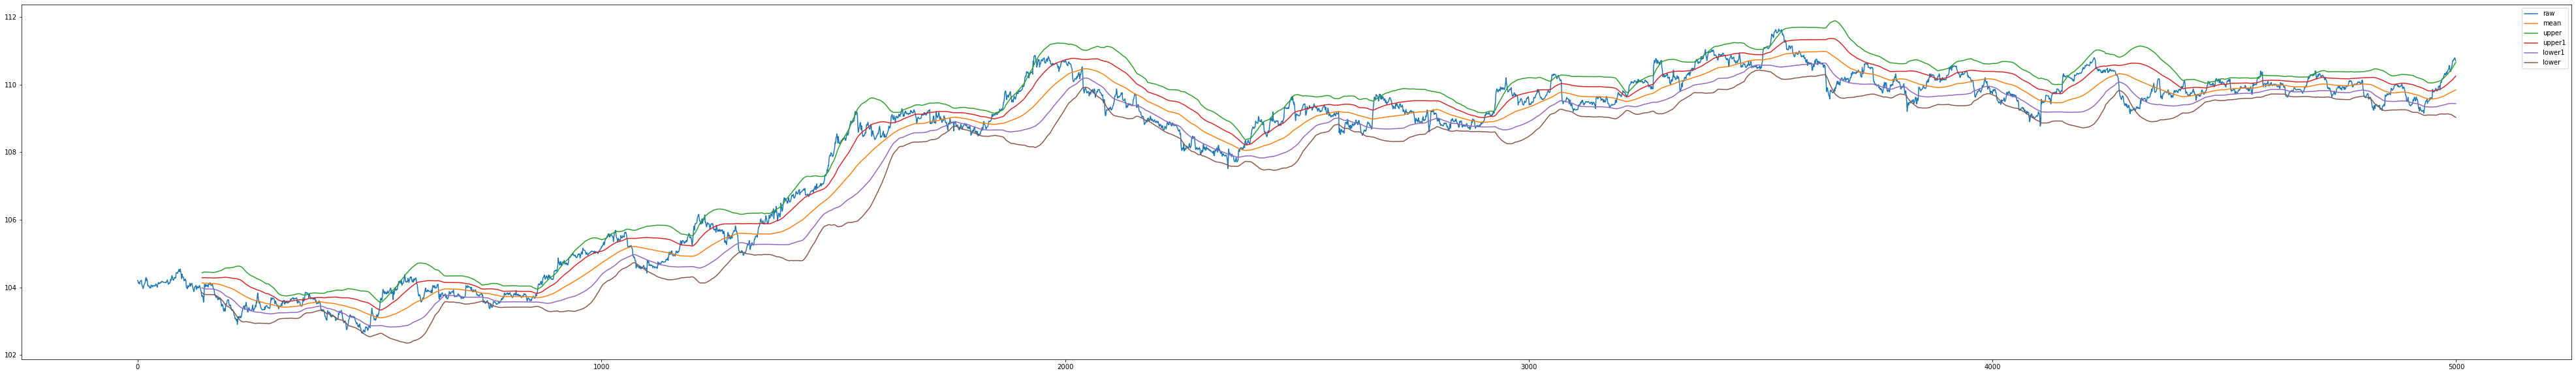

In [12]:

test = dd.bband(window=140)

test = test[['raw', 'time', 'mean', 'upper', 'upper1', 'lower1',
       'lower', ]]
test.plot(figsize=(70, 10))


In [13]:

class Trade:
    def __init__(self, arr):
        self.position = 0
        self.inPrice = 0
        self.timeAfterOrder = 0
        self.profit = 0
        self.arr = arr
        self.won = 0
        self.lost = 0
        # weighted score
        self.N = 0
        self.wScore = 0
    def long(self,i,  ):
        if self.position == 0:
            self.inPrice = self.arr[i]
            self.position = 1
            self.timeAfterOrder = 0
            print(">>> LONG")
        elif self.position == 1:
            pass
        elif self.position == -1:
            self.close(i)
    def short(self, i, ):
        if self.position == 0:
            self.inPrice = self.arr[i]
            self.position = -1
            self.timeAfterOrder = 0
            print(">>> SHORT")
        elif self.position == 1:
            self.close(i)
        elif self.position == -1:
            pass  
    def close(self,i):
        if self.position > 0:
            profit = self.arr[i] - self.inPrice
        elif self.position < 0:
            profit = self.inPrice - self.arr[i]
        else:
            profit = None
        if profit != None:
            print("profit: ", profit)
        else:
            print("WARNING >>>>> DID NOT HAVE ANY POSITION BUT CLOSING...")
        self.profit += profit
        self.position = 0  
        self.timeAfterOrder = 0
        # update win ratio
        if profit > 0:
            self.won += 1
        elif profit < 0:
            self.lost += 1
        # update wScore
        self.N += 1
        self.wScore = (self.wScore * (self.N-1) * 0.9 + profit) / self.N
        print("total profit: ", self.profit)


In [14]:
data = Data("M30", 5000)
# optW = 140
optW = chooseOptPolicy(data, fitBBWindow=3000)
print("optW :", optW)
optW = 200 # manual
bb = data.bband(window=optW,)

{30: (68, 67), 40: (51, 70), 50: (44, 46), 60: (39, 41), 70: (37, 40), 80: (33, 36), 90: (36, 38), 100: (35, 31), 110: (32, 26), 120: (37, 31), 130: (35, 27), 140: (33, 27), 150: (32, 28), 160: (32, 19), 170: (28, 19), 180: (33, 21), 190: (30, 18), 200: (26, 20), 210: (26, 19), 220: (23, 15), 230: (26, 13), 240: (23, 12), 250: (30, 12), 260: (27, 9), 270: (26, 9), 280: (23, 8), 290: (23, 4)}
optW : 30


<AxesSubplot:>

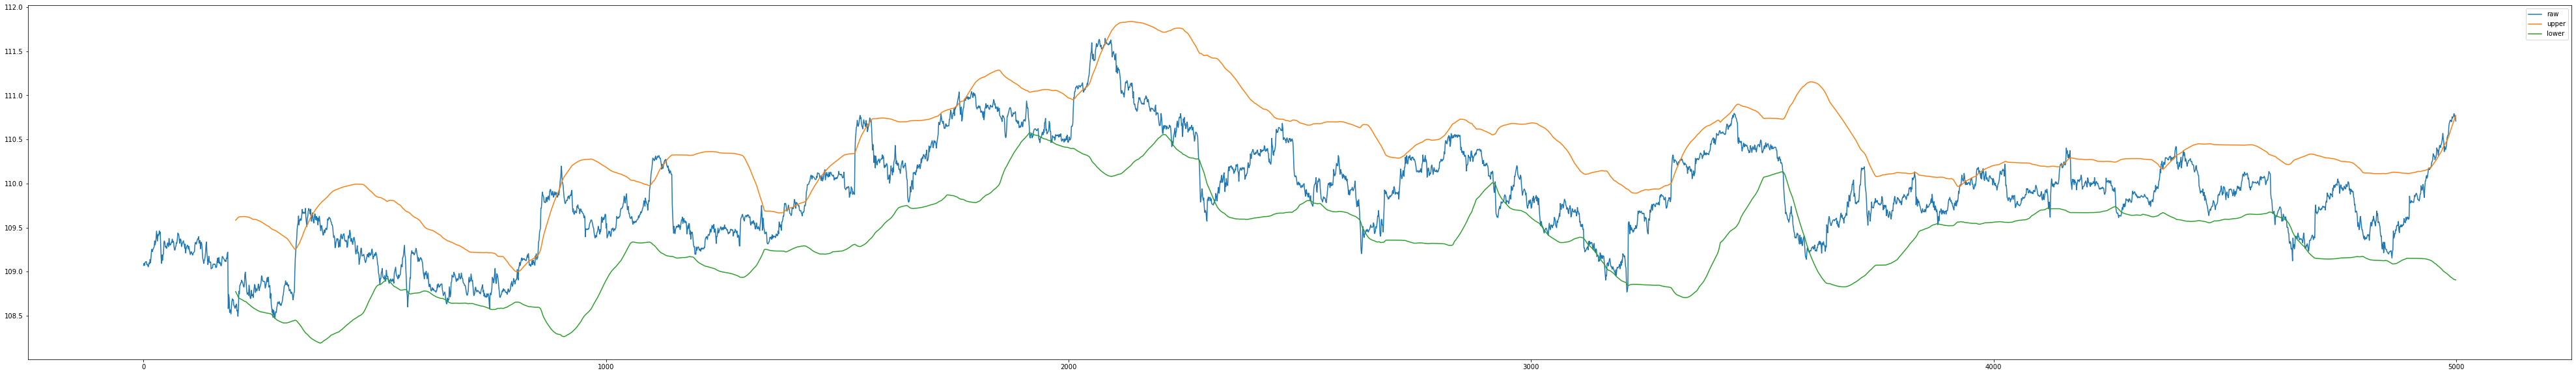

In [15]:
bb[["raw", "upper", "lower"]].plot(figsize=(70, 10))

In [16]:
row = bb.iloc[0]

In [ ]:
# hyper param
# SPAN ["M10", "M30", "M1", "M5"]
data = Data("M30", 5000)
# optW  
#optW = chooseOptPolicy(data, fitBBWindow=3000)
#NOT use chooseOptPolicy, do simulation instead
bb = data.bband(window=optW,)

In [20]:
# Policy Run
def bbSimulate(SPAN, LENGTH, optW): # SPAN is oanda granularity
	data = Data(SPAN, LENGTH)
	bb = data.bband(window=optW,)
	i = optW 
	t = Trade(bb["raw"].to_numpy() )
	inAbove = False
	inBelow = False
	# fromAbove = False
	# fromBelow = False

	while i < len(bb):
		row = bb.iloc[i]
		if row["raw"] > row["upper"]:
			if t.position == 1:
				t.short(i)
				print(row["time"])
			if inAbove:
				pass
			else:
				inAbove = True
		elif row["raw"] < row["lower"]:
			if t.position == -1:
				t.long(i)
				print(row["time"])
			if inBelow:
				pass
			else:
				inBelow = True
		else:
			if inAbove:
				t.short(i)
				inAbove = False
			elif inBelow:
				t.long(i)
				inBelow = False
			else:
				pass
		i += 1
		
	print("************\n*************END") 
	return t.profit, round(t.won / (t.won + t.lost),2), t.wScore

In [21]:
spans = [("M30",5000), ("H1",2500), ("H2",1250)]
bbWindows = [i for i in range(30,300, 10)]
result = []
for span in spans:
	for bbWindow in bbWindows:
		r = bbSimulate(span[0],span[1], bbWindow)
		result.append(((span, bbWindow), r))

>>> SHORT
profit:  0.1559999999999917
total profit:  0.1559999999999917
2021-05-05T14:30:00.000000000Z
>>> LONG
profit:  0.10999999999999943
total profit:  0.26599999999999113
2021-05-06T03:30:00.000000000Z
>>> SHORT
profit:  0.27899999999999636
total profit:  0.5449999999999875
2021-05-06T10:00:00.000000000Z
>>> LONG
profit:  0.05100000000000193
total profit:  0.5959999999999894
2021-05-07T06:30:00.000000000Z
>>> SHORT
profit:  0.578000000000003
total profit:  1.1739999999999924
2021-05-07T12:30:00.000000000Z
>>> SHORT
profit:  -0.05300000000001148
total profit:  1.120999999999981
>>> SHORT
profit:  0.19000000000001194
total profit:  1.3109999999999928
2021-05-11T10:00:00.000000000Z
>>> LONG
profit:  0.02600000000001046
total profit:  1.3370000000000033
2021-05-12T00:30:00.000000000Z
>>> SHORT
profit:  -0.6090000000000089
total profit:  0.7279999999999944
2021-05-13T16:30:00.000000000Z
>>> LONG
profit:  -0.04999999999999716
total profit:  0.6779999999999973
2021-05-17T00:00:00.0000000

>>> LONG
profit:  -0.05500000000000682
total profit:  -0.05500000000000682
2021-05-07T11:30:00.000000000Z
>>> SHORT
profit:  -0.05300000000001148
total profit:  -0.1080000000000183
>>> SHORT
profit:  0.24800000000000466
total profit:  0.13999999999998636
2021-05-11T10:00:00.000000000Z
>>> LONG
profit:  0.24800000000000466
total profit:  0.387999999999991
2021-05-12T12:30:00.000000000Z
>>> SHORT
profit:  0.11499999999999488
total profit:  0.5029999999999859
2021-05-13T16:30:00.000000000Z
>>> LONG
profit:  -0.44199999999999307
total profit:  0.06099999999999284
2021-05-19T07:30:00.000000000Z
>>> SHORT
profit:  0.3200000000000074
total profit:  0.3810000000000002
2021-05-19T14:00:00.000000000Z
>>> LONG
profit:  0.25799999999999557
total profit:  0.6389999999999958
2021-05-21T14:30:00.000000000Z
>>> SHORT
profit:  0.20600000000000307
total profit:  0.8449999999999989
2021-05-24T07:00:00.000000000Z
>>> LONG
profit:  0.17499999999999716
total profit:  1.019999999999996
2021-05-25T10:00:00.00

profit:  0.16400000000000148
total profit:  2.037000000000006
2021-06-28T11:30:00.000000000Z
>>> SHORT
profit:  0.36599999999999966
total profit:  2.403000000000006
2021-06-28T15:00:00.000000000Z
>>> LONG
profit:  0.09099999999999397
total profit:  2.4939999999999998
2021-06-30T12:00:00.000000000Z
>>> SHORT
profit:  -0.19199999999999307
total profit:  2.3020000000000067
2021-07-02T12:30:00.000000000Z
>>> LONG
profit:  -0.9279999999999973
total profit:  1.3740000000000094
2021-07-09T08:30:00.000000000Z
>>> SHORT
profit:  -0.16100000000000136
total profit:  1.213000000000008
2021-07-14T12:30:00.000000000Z
>>> LONG
profit:  0.14399999999999125
total profit:  1.3569999999999993
2021-07-16T07:30:00.000000000Z
>>> SHORT
profit:  0.3149999999999977
total profit:  1.671999999999997
2021-07-19T08:00:00.000000000Z
>>> LONG
profit:  -0.04800000000000182
total profit:  1.6239999999999952
2021-07-20T14:00:00.000000000Z
>>> SHORT
profit:  -0.22499999999999432
total profit:  1.399000000000001
2021-07

profit:  0.25199999999999534
total profit:  2.262000000000043
2021-09-22T18:30:00.000000000Z
>>> SHORT
************
*************END
>>> LONG
profit:  -0.015000000000000568
total profit:  -0.015000000000000568
2021-05-12T13:00:00.000000000Z
>>> SHORT
profit:  0.28700000000000614
total profit:  0.27200000000000557
2021-05-14T06:30:00.000000000Z
>>> LONG
profit:  -0.15800000000000125
total profit:  0.11400000000000432
2021-05-19T10:30:00.000000000Z
>>> SHORT
profit:  0.45000000000000284
total profit:  0.5640000000000072
2021-05-19T14:00:00.000000000Z
>>> LONG
profit:  0.4510000000000076
total profit:  1.0150000000000148
2021-05-19T18:30:00.000000000Z
>>> SHORT
profit:  0.6290000000000049
total profit:  1.6440000000000197
2021-05-25T07:00:00.000000000Z
>>> LONG
profit:  0.2560000000000002
total profit:  1.90000000000002
2021-05-25T12:30:00.000000000Z
>>> SHORT
profit:  -0.7579999999999956
total profit:  1.1420000000000243
2021-05-31T01:00:00.000000000Z
>>> LONG
profit:  -0.022999999999996

>>> LONG
profit:  -0.015000000000000568
total profit:  -0.015000000000000568
2021-05-12T13:00:00.000000000Z
>>> SHORT
profit:  0.3410000000000082
total profit:  0.3260000000000076
2021-05-14T11:30:00.000000000Z
>>> LONG
profit:  -0.02599999999999625
total profit:  0.30000000000001137
2021-05-19T11:00:00.000000000Z
>>> SHORT
profit:  0.41199999999999193
total profit:  0.7120000000000033
2021-05-19T13:30:00.000000000Z
>>> LONG
profit:  0.2750000000000057
total profit:  0.987000000000009
2021-05-25T13:00:00.000000000Z
>>> SHORT
profit:  -0.4749999999999943
total profit:  0.5120000000000147
2021-05-31T14:30:00.000000000Z
>>> LONG
profit:  0.2360000000000042
total profit:  0.7480000000000189
2021-06-02T06:30:00.000000000Z
>>> SHORT
profit:  0.465999999999994
total profit:  1.2140000000000128
2021-06-10T19:00:00.000000000Z
>>> LONG
profit:  0.39400000000000546
total profit:  1.6080000000000183
2021-06-11T13:30:00.000000000Z
>>> SHORT
profit:  -0.24099999999999966
total profit:  1.36700000000

profit:  0.07199999999998852
total profit:  1.2119999999999749
2021-06-30T14:00:00.000000000Z
>>> SHORT
profit:  0.21599999999999397
total profit:  1.4279999999999688
2021-07-05T09:00:00.000000000Z
>>> LONG
profit:  -0.3340000000000032
total profit:  1.0939999999999657
2021-07-13T12:30:00.000000000Z
>>> SHORT
profit:  0.36099999999999
total profit:  1.4549999999999557
2021-07-14T13:30:00.000000000Z
>>> LONG
profit:  0.17600000000000193
total profit:  1.6309999999999576
2021-07-21T08:00:00.000000000Z
>>> SHORT
profit:  0.015000000000000568
total profit:  1.6459999999999582
2021-07-27T07:00:00.000000000Z
>>> LONG
profit:  -0.5619999999999976
total profit:  1.0839999999999606
2021-08-04T14:30:00.000000000Z
>>> SHORT
profit:  -0.695999999999998
total profit:  0.3879999999999626
2021-08-13T13:00:00.000000000Z
>>> LONG
profit:  0.31100000000000705
total profit:  0.6989999999999696
2021-08-18T10:30:00.000000000Z
>>> SHORT
profit:  0.20100000000000762
total profit:  0.8999999999999773
2021-08-

profit:  0.2670000000000101
total profit:  1.8400000000000034
2021-08-24T12:30:00.000000000Z
>>> LONG
profit:  0.39500000000001023
total profit:  2.2350000000000136
2021-08-25T14:00:00.000000000Z
>>> SHORT
profit:  0.29999999999999716
total profit:  2.535000000000011
2021-08-30T00:30:00.000000000Z
>>> LONG
profit:  0.3999999999999915
total profit:  2.9350000000000023
2021-09-01T00:00:00.000000000Z
>>> SHORT
profit:  0.5100000000000051
total profit:  3.4450000000000074
2021-09-03T13:00:00.000000000Z
>>> LONG
profit:  0.39700000000000557
total profit:  3.842000000000013
2021-09-07T12:30:00.000000000Z
>>> SHORT
profit:  0.5939999999999941
total profit:  4.436000000000007
2021-09-09T17:00:00.000000000Z
>>> LONG
profit:  0.3300000000000125
total profit:  4.7660000000000196
2021-09-17T12:30:00.000000000Z
>>> SHORT
profit:  0.722999999999999
total profit:  5.4890000000000185
2021-09-21T12:30:00.000000000Z
>>> LONG
profit:  0.6620000000000061
total profit:  6.151000000000025
2021-09-23T07:00:0

profit:  0.4379999999999882
total profit:  2.9219999999999544
2021-08-25T12:30:00.000000000Z
>>> SHORT
profit:  0.2599999999999909
total profit:  3.1819999999999453
2021-08-31T12:30:00.000000000Z
>>> LONG
profit:  0.4239999999999924
total profit:  3.6059999999999377
2021-09-01T01:00:00.000000000Z
>>> SHORT
profit:  0.4519999999999982
total profit:  4.057999999999936
2021-09-03T13:00:00.000000000Z
>>> LONG
profit:  0.4720000000000084
total profit:  4.529999999999944
2021-09-07T13:00:00.000000000Z
>>> SHORT
profit:  0.46000000000000796
total profit:  4.989999999999952
2021-09-14T14:30:00.000000000Z
>>> LONG
profit:  0.4420000000000073
total profit:  5.4319999999999595
2021-09-23T14:30:00.000000000Z
>>> SHORT
************
*************END
>>> LONG
profit:  0.4579999999999984
total profit:  0.4579999999999984
2021-05-12T13:30:00.000000000Z
>>> SHORT
profit:  0.6090000000000089
total profit:  1.0670000000000073
2021-05-18T08:00:00.000000000Z
>>> LONG
profit:  0.03499999999999659
total profi

profit:  0.8269999999999982
total profit:  3.498000000000019
2021-08-25T14:30:00.000000000Z
>>> SHORT
profit:  0.42199999999999704
total profit:  3.920000000000016
2021-08-31T14:00:00.000000000Z
>>> LONG
profit:  0.35599999999999454
total profit:  4.2760000000000105
2021-09-01T01:00:00.000000000Z
>>> SHORT
profit:  0.4899999999999949
total profit:  4.766000000000005
2021-09-03T13:30:00.000000000Z
>>> LONG
profit:  0.6350000000000051
total profit:  5.4010000000000105
2021-09-07T18:30:00.000000000Z
>>> SHORT
profit:  0.6270000000000095
total profit:  6.02800000000002
2021-09-14T14:30:00.000000000Z
>>> LONG
profit:  0.578000000000003
total profit:  6.606000000000023
2021-09-23T18:30:00.000000000Z
>>> SHORT
************
*************END
>>> LONG
profit:  0.909000000000006
total profit:  0.909000000000006
2021-05-12T15:00:00.000000000Z
>>> SHORT
profit:  0.7879999999999967
total profit:  1.6970000000000027
2021-05-19T13:30:00.000000000Z
>>> LONG
profit:  0.39799999999999613
total profit:  2

>>> LONG
profit:  -0.22700000000000387
total profit:  -0.22700000000000387
2021-05-12T12:00:00.000000000Z
>>> SHORT
profit:  0.2009999999999934
total profit:  -0.02600000000001046
2021-05-14T06:00:00.000000000Z
>>> LONG
profit:  -0.2219999999999942
total profit:  -0.24800000000000466
2021-05-19T09:00:00.000000000Z
>>> SHORT
profit:  0.42600000000000193
total profit:  0.17799999999999727
2021-05-19T14:00:00.000000000Z
>>> LONG
profit:  0.22100000000000364
total profit:  0.3990000000000009
2021-05-25T12:00:00.000000000Z
>>> SHORT
profit:  -0.730000000000004
total profit:  -0.33100000000000307
2021-05-31T02:00:00.000000000Z
>>> LONG
profit:  0.0010000000000047748
total profit:  -0.3299999999999983
2021-06-02T04:00:00.000000000Z
>>> SHORT
profit:  0.2710000000000008
total profit:  -0.0589999999999975
2021-06-04T13:00:00.000000000Z
>>> LONG
profit:  0.09199999999999875
total profit:  0.03300000000000125
2021-06-09T14:00:00.000000000Z
>>> SHORT
profit:  0.028999999999996362
total profit:  0.

>>> LONG
profit:  0.07000000000000739
total profit:  0.07000000000000739
2021-05-12T13:00:00.000000000Z
>>> SHORT
profit:  0.4620000000000033
total profit:  0.5320000000000107
2021-05-17T06:00:00.000000000Z
>>> LONG
profit:  -0.20600000000000307
total profit:  0.3260000000000076
2021-05-26T14:00:00.000000000Z
>>> SHORT
profit:  -0.2710000000000008
total profit:  0.05500000000000682
2021-05-31T14:00:00.000000000Z
>>> LONG
profit:  0.2740000000000009
total profit:  0.32900000000000773
2021-06-02T07:00:00.000000000Z
>>> SHORT
profit:  0.4590000000000032
total profit:  0.7880000000000109
2021-06-10T19:00:00.000000000Z
>>> LONG
profit:  0.4140000000000015
total profit:  1.2020000000000124
2021-06-11T14:00:00.000000000Z
>>> SHORT
profit:  -0.1839999999999975
total profit:  1.018000000000015
2021-06-16T12:00:00.000000000Z
>>> LONG
profit:  0.561000000000007
total profit:  1.579000000000022
2021-06-16T18:00:00.000000000Z
>>> SHORT
profit:  -0.025000000000005684
total profit:  1.554000000000016

>>> LONG
profit:  0.4890000000000043
total profit:  0.4890000000000043
2021-05-12T13:00:00.000000000Z
>>> SHORT
profit:  0.5440000000000111
total profit:  1.0330000000000155
2021-05-18T07:00:00.000000000Z
>>> LONG
profit:  0.03999999999999204
total profit:  1.0730000000000075
2021-05-26T14:00:00.000000000Z
>>> SHORT
profit:  -1.440000000000012
total profit:  -0.36700000000000443
2021-06-28T15:00:00.000000000Z
>>> LONG
profit:  0.3689999999999998
total profit:  0.001999999999995339
2021-06-30T14:00:00.000000000Z
>>> SHORT
profit:  0.7860000000000014
total profit:  0.7879999999999967
2021-07-08T05:00:00.000000000Z
>>> LONG
profit:  0.8580000000000041
total profit:  1.6460000000000008
2021-07-13T17:00:00.000000000Z
>>> SHORT
profit:  0.6910000000000025
total profit:  2.3370000000000033
2021-07-15T00:00:00.000000000Z
>>> LONG
profit:  0.18999999999999773
total profit:  2.527000000000001
2021-08-06T12:00:00.000000000Z
>>> SHORT
profit:  0.05700000000000216
total profit:  2.584000000000003
2

>>> LONG
profit:  0.9899999999999949
total profit:  0.9899999999999949
2021-05-12T15:00:00.000000000Z
>>> SHORT
profit:  1.0090000000000003
total profit:  1.9989999999999952
2021-05-19T14:00:00.000000000Z
>>> LONG
profit:  0.47100000000000364
total profit:  2.469999999999999
2021-05-27T11:00:00.000000000Z
>>> SHORT
profit:  -0.4269999999999925
total profit:  2.0430000000000064
2021-07-08T05:00:00.000000000Z
>>> LONG
profit:  0.3100000000000023
total profit:  2.3530000000000086
2021-08-06T12:00:00.000000000Z
>>> SHORT
profit:  0.4749999999999943
total profit:  2.828000000000003
2021-08-13T15:00:00.000000000Z
>>> LONG
profit:  0.8299999999999983
total profit:  3.6580000000000013
2021-08-23T11:00:00.000000000Z
>>> SHORT
profit:  0.35299999999999443
total profit:  4.010999999999996
2021-09-03T13:00:00.000000000Z
>>> LONG
profit:  0.6000000000000085
total profit:  4.611000000000004
2021-09-07T18:00:00.000000000Z
>>> SHORT
profit:  0.6340000000000003
total profit:  5.2450000000000045
2021-09

profit:  0.8499999999999943
total profit:  1.0249999999999773
2021-09-14T17:00:00.000000000Z
>>> LONG
profit:  0.7019999999999982
total profit:  1.7269999999999754
2021-09-23T20:00:00.000000000Z
************
*************END
>>> SHORT
profit:  -0.39700000000000557
total profit:  -0.39700000000000557
2021-07-08T06:00:00.000000000Z
>>> LONG
profit:  0.5719999999999885
total profit:  0.17499999999998295
2021-08-10T08:00:00.000000000Z
>>> SHORT
profit:  0.8259999999999934
total profit:  1.0009999999999764
2021-09-14T16:00:00.000000000Z
>>> LONG
profit:  0.6119999999999948
total profit:  1.6129999999999711
2021-09-23T19:00:00.000000000Z
************
*************END
>>> SHORT
profit:  -0.39700000000000557
total profit:  -0.39700000000000557
2021-07-08T06:00:00.000000000Z
>>> LONG
profit:  0.6499999999999915
total profit:  0.2529999999999859
2021-08-10T13:00:00.000000000Z
>>> SHORT
profit:  0.9380000000000024
total profit:  1.1909999999999883
2021-09-09T17:00:00.000000000Z
>>> LONG
profit:  

>>> SHORT
profit:  0.9710000000000036
total profit:  0.9710000000000036
2021-05-19T13:00:00.000000000Z
>>> LONG
profit:  0.3470000000000084
total profit:  1.318000000000012
2021-05-26T23:00:00.000000000Z
>>> SHORT
profit:  -1.088000000000008
total profit:  0.23000000000000398
2021-07-08T05:00:00.000000000Z
>>> LONG
profit:  0.3359999999999985
total profit:  0.5660000000000025
2021-08-06T11:00:00.000000000Z
>>> SHORT
profit:  0.3960000000000008
total profit:  0.9620000000000033
2021-08-13T13:00:00.000000000Z
>>> LONG
profit:  0.8229999999999933
total profit:  1.7849999999999966
2021-08-25T13:00:00.000000000Z
>>> SHORT
profit:  0.3919999999999959
total profit:  2.1769999999999925
2021-09-03T13:00:00.000000000Z
>>> LONG
profit:  0.585000000000008
total profit:  2.7620000000000005
2021-09-07T17:00:00.000000000Z
>>> SHORT
profit:  0.6260000000000048
total profit:  3.3880000000000052
2021-09-14T13:00:00.000000000Z
>>> LONG
profit:  0.6150000000000091
total profit:  4.003000000000014
2021-09-

>>> SHORT
profit:  -0.07299999999999329
total profit:  -0.07299999999999329
2021-07-08T07:00:00.000000000Z
>>> LONG
profit:  0.4140000000000015
total profit:  0.3410000000000082
2021-09-07T17:00:00.000000000Z
>>> SHORT
profit:  0.6859999999999928
total profit:  1.027000000000001
2021-09-14T23:00:00.000000000Z
>>> LONG
profit:  0.8130000000000024
total profit:  1.8400000000000034
2021-09-24T03:00:00.000000000Z
>>> SHORT
************
*************END
>>> SHORT
profit:  -0.07299999999999329
total profit:  -0.07299999999999329
2021-07-08T07:00:00.000000000Z
>>> LONG
profit:  0.9200000000000017
total profit:  0.8470000000000084
2021-08-11T07:00:00.000000000Z
>>> SHORT
profit:  1.1700000000000017
total profit:  2.01700000000001
2021-09-14T23:00:00.000000000Z
>>> LONG
profit:  0.8130000000000024
total profit:  2.8300000000000125
2021-09-24T03:00:00.000000000Z
>>> SHORT
************
*************END
>>> SHORT
profit:  -0.031999999999996476
total profit:  -0.031999999999996476
2021-07-08T09:00:

In [22]:
result

[((('M30', 5000), 30), (-0.3150000000000688, 0.64, 0.00013106734391686383)),
 ((('M30', 5000), 40), (3.1899999999999125, 0.67, 0.007346975315191573)),
 ((('M30', 5000), 50), (4.413999999999987, 0.66, 0.01570681255416647)),
 ((('M30', 5000), 60), (2.262000000000043, 0.63, 0.008097298688605467)),
 ((('M30', 5000), 70), (3.2369999999999663, 0.68, 0.006694984130623777)),
 ((('M30', 5000), 80), (3.566999999999993, 0.68, 0.023187698694908866)),
 ((('M30', 5000), 90), (5.358000000000061, 0.74, 0.03659847054624478)),
 ((('M30', 5000), 100), (5.109999999999971, 0.69, 0.05615761452060589)),
 ((('M30', 5000), 110), (3.82499999999996, 0.69, 0.07053688662094938)),
 ((('M30', 5000), 120), (5.471999999999994, 0.76, 0.09759993753832259)),
 ((('M30', 5000), 130), (4.998000000000019, 0.8, 0.12081506267302253)),
 ((('M30', 5000), 140), (6.151000000000025, 0.91, 0.1593291666996848)),
 ((('M30', 5000), 150), (5.603000000000037, 0.86, 0.1406700929974854)),
 ((('M30', 5000), 160), (6.209999999999994, 0.95, 0

In [25]:
[ o for o in sorted(result, key=lambda x:x[1][0], reverse=True) if o[1][1] > 0.85]

[((('M30', 5000), 280), (7.166000000000011, 0.92, 0.309352597341873)),
 ((('H1', 2500), 170), (7.004999999999981, 0.92, 0.3502873457559021)),
 ((('M30', 5000), 240), (6.795999999999978, 0.93, 0.25539583346541544)),
 ((('M30', 5000), 230), (6.606000000000023, 0.93, 0.2539532922682484)),
 ((('M30', 5000), 160), (6.209999999999994, 0.95, 0.17744343245782068)),
 ((('M30', 5000), 140), (6.151000000000025, 0.91, 0.1593291666996848)),
 ((('H2', 1250), 70), (6.108000000000018, 0.91, 0.34052129925005575)),
 ((('M30', 5000), 290), (6.090000000000003, 0.92, 0.3015210391942372)),
 ((('H1', 2500), 70), (5.998000000000033, 0.9, 0.14867013075571153)),
 ((('M30', 5000), 250), (5.801000000000016, 0.92, 0.2699739121051828)),
 ((('H1', 2500), 140), (5.765000000000001, 0.91, 0.32348596988272726)),
 ((('H1', 2500), 80), (5.746000000000038, 0.94, 0.18806933494058872)),
 ((('M30', 5000), 170), (5.742999999999995, 0.94, 0.19413149745278718)),
 ((('M30', 5000), 150), (5.603000000000037, 0.86, 0.140670092997485

In [ ]:
SPAN = "M30"
optW = 
data = Data("M30", 5000)
bb = data.bband(window=optW,)

In [23]:
[(o[0][0][0], o[0][1] ) for o in sorted(result, key=lambda x:x[1][0], reverse=True) if o[1][1] > 0.85]

[('M30', 280),
 ('H1', 170),
 ('M30', 240),
 ('M30', 230),
 ('M30', 160),
 ('M30', 140),
 ('H2', 70),
 ('M30', 290),
 ('H1', 70),
 ('M30', 250),
 ('H1', 140),
 ('H1', 80),
 ('M30', 170),
 ('M30', 150),
 ('M30', 270),
 ('M30', 220),
 ('M30', 180),
 ('H1', 100),
 ('M30', 200),
 ('M30', 210),
 ('H2', 40),
 ('H1', 150),
 ('H1', 130),
 ('H1', 120),
 ('H2', 80),
 ('H1', 190),
 ('H2', 100),
 ('M30', 260),
 ('H1', 160),
 ('H2', 50),
 ('H1', 200),
 ('H2', 90),
 ('H2', 290),
 ('H1', 90),
 ('M30', 190),
 ('H2', 60),
 ('H1', 180),
 ('H2', 270),
 ('H2', 280),
 ('H2', 260),
 ('H2', 250),
 ('H2', 240),
 ('H2', 230),
 ('H2', 220)]

In [1]:
# plot and check
data = Data("H1", 2500)
bb = data.bband(window=170)
bb[["raw", "upper", "lower"]].plot(figsize=(15,5))


NameError: name 'Data' is not defined

<AxesSubplot:>

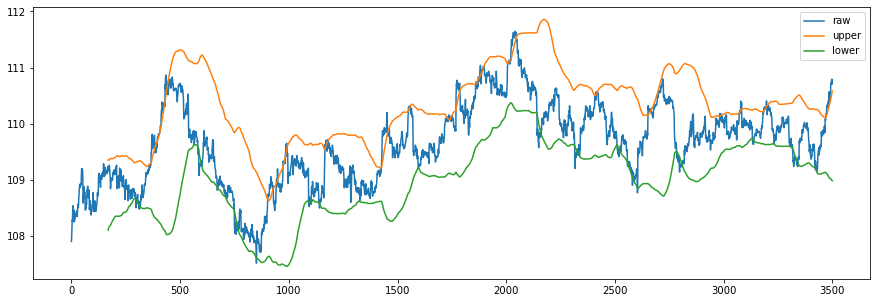

In [195]:

# plot and check
data = Data("H1", 3500)
bb = data.bband(window=170)
bb[["raw", "upper", "lower"]].plot(figsize=(15,5))

<AxesSubplot:>

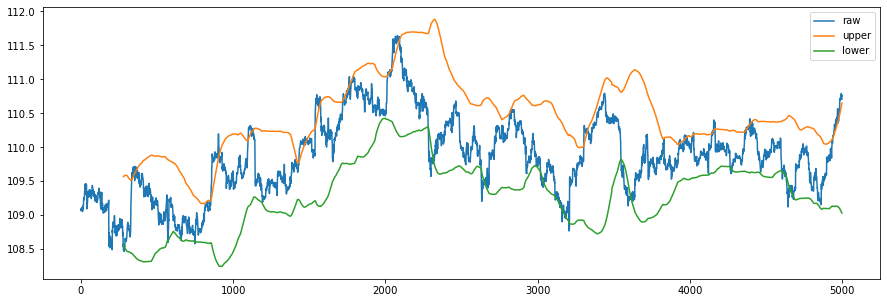

In [193]:

# plot and check
data = Data("M30", 5000)
bb = data.bband(window=280)
bb[["raw", "upper", "lower"]].plot(figsize=(15,5))